### Master of Applied Artificial Intelligence

**Course: TC4033 - Autonomous Driving**

<img src="https://github.com/alcalderagl/self_driving_car/blob/main/images/logo.png?raw=1" alt="TEC DE MONTERREY" width="500"/>

**PEDESTRIAN DETECTION WITH HOG AND SVM**

Tutor: Dr. David Antonio Torres


Team members:
* Rafael Bernando Orozco Palma - A01795359
* Arantxa Stephania Coronel González - A01620352
* Alejandro Calderon Aguilar - A01795353

# Import libraries

In [27]:
!git clone https://github.com/alcalderagl/self_driving_car.git

fatal: destination path 'self_driving_car' already exists and is not an empty directory.


In [28]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog
import glob
import os
import sys
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# from src.utils.utils import Utils

import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import sys
sys.path.append('/content/self_driving_car/src/utils')

from utils import Utils





In [29]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Global variables

In [30]:
nrows = 5
ncols = 2
figsize=(12, 18)
utils = Utils()

# Import pedestrian dataset
### https://www.kaggle.com/datasets/karthika95/pedestrian-detection?resource=download

In [31]:
pedestrians_df = pd.read_pickle("/content/self_driving_car/data/pedestrians/processed/train/hog_pedestrians_dataset.pkl")
pedestrians_df["filename"] = pedestrians_df["filename"].apply(
    lambda path: "/content/self_driving_car/data/pedestrians/processed/train/img/" + os.path.basename(path)
)
pedestrians_df.head()

,filename,label,features
0,/content/self_driving_car/data/pedestrians/pro...,1,"[0.17621226757272837, 0.11970332756318078, 0.2..."
1,/content/self_driving_car/data/pedestrians/pro...,1,"[0.17434682525850692, 0.16302948567861925, 0.1..."
2,/content/self_driving_car/data/pedestrians/pro...,1,"[0.14285142494707212, 0.038435981037694036, 0...."
3,/content/self_driving_car/data/pedestrians/pro...,1,"[0.09548145701380828, 0.025004826031810708, 0...."
4,/content/self_driving_car/data/pedestrians/pro...,1,"[0.2433784390606614, 0.010232653819074329, 0.0..."


# Get dataset description

In [32]:
# How many images are in the dataset
pedestrians_df.count()

,0
filename,2066
label,2066
features,2066


In [33]:
# Identify how many possible classes are in the dataset to classify
pedestrians_df["label"].value_counts()

,count
label,
1,1106
0,960


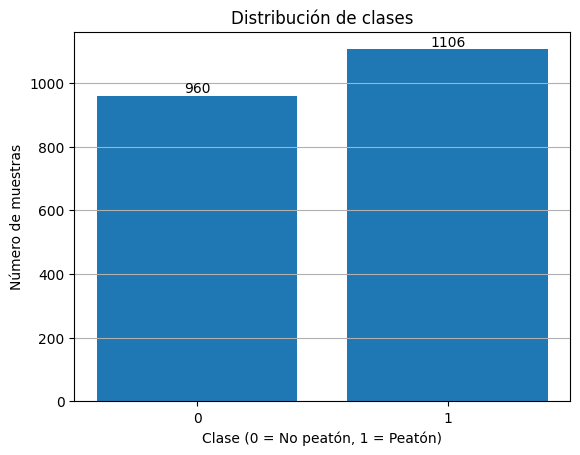

In [34]:
counts = pedestrians_df["label"].value_counts().sort_index()

plt.bar([0, 1], counts.values)
plt.xticks([0, 1])
plt.xlabel("Clase (0 = No peatón, 1 = Peatón)")
plt.ylabel("Número de muestras")
plt.title("Distribución de clases")
plt.grid(axis='y')

for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

# Show a sample of pedestrian images

In [35]:
# sample of 10 rows
random_pedestrians = pedestrians_df.sample(n=10)
# show the 5 rows
random_pedestrians.head()

,filename,label,features
508,/content/self_driving_car/data/pedestrians/pro...,1,"[0.1199020302900776, 0.05944927995136163, 0.18..."
617,/content/self_driving_car/data/pedestrians/pro...,1,"[0.2615568784931474, 0.2601300526974257, 0.152..."
120,/content/self_driving_car/data/pedestrians/pro...,1,"[0.012235793458341823, 0.0012052856365824868, ..."
254,/content/self_driving_car/data/pedestrians/pro...,1,"[0.12664481526883042, 0.08591884716629099, 0.0..."
1339,/content/self_driving_car/data/pedestrians/pro...,0,"[0.07650695270550924, 0.049328935241456505, 0...."


In [36]:
# get the file path image of sample
tmp_pedestrian_path_imgs= random_pedestrians.get("filename").to_list()
# a variable to specify if the image is a pedestrian or not
tmp_pedestrian_labels = random_pedestrians.get("label").apply(lambda x: "Pedestrian" if x == 1 else "Not pedestrian").to_list()

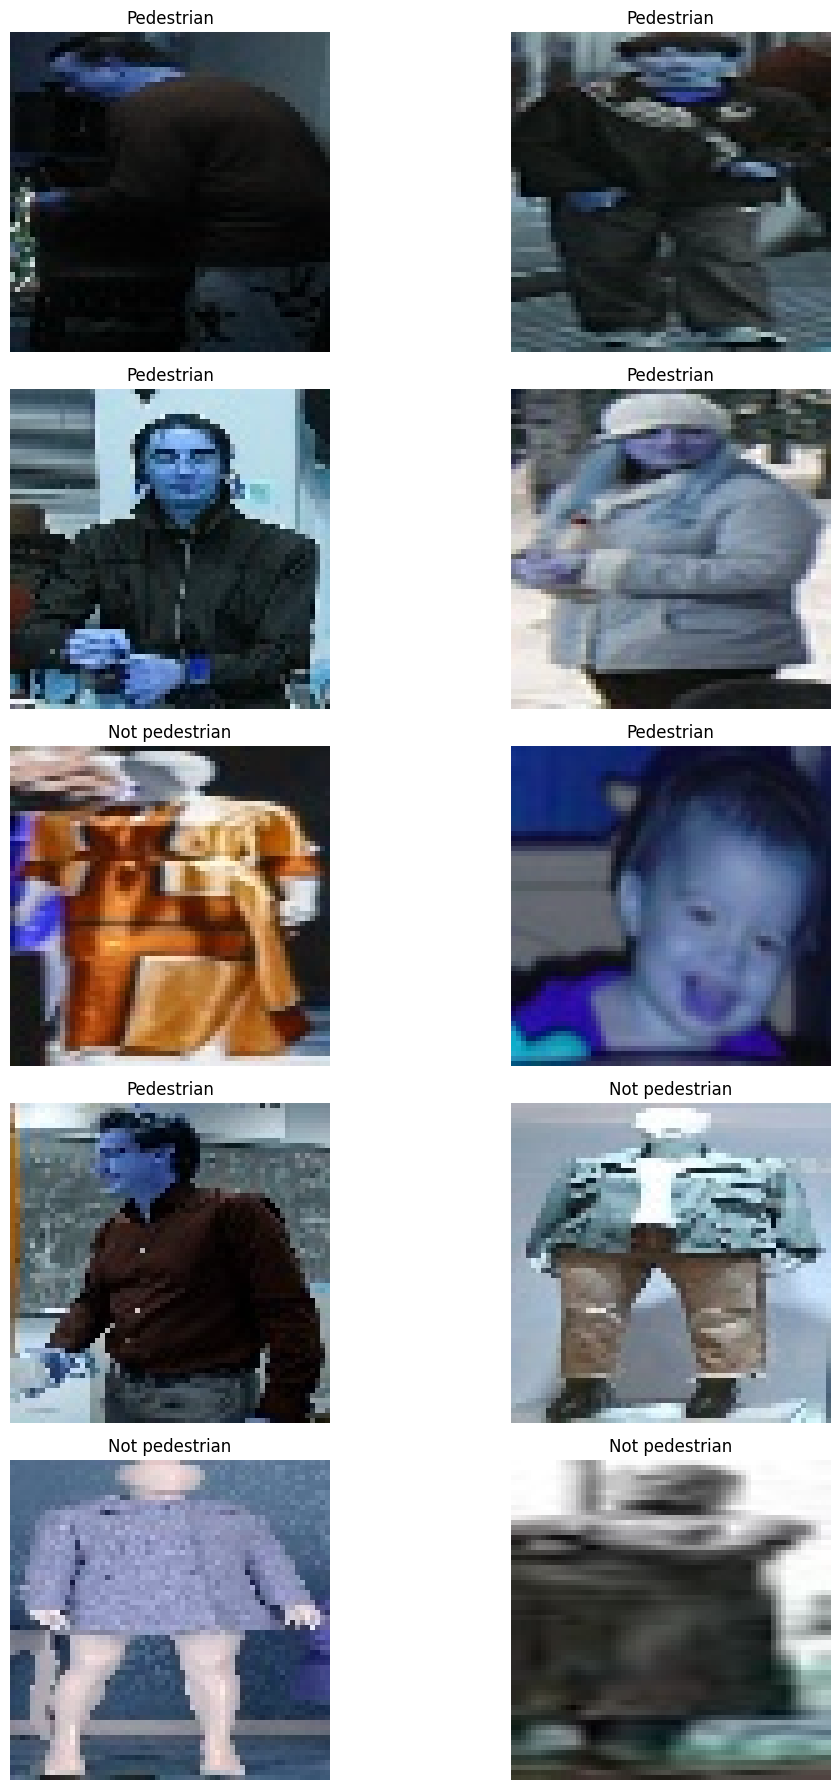

In [37]:
# with utils read_images method, get an array of images gotten in sample dataset
tmp_pedestrian_imgs = utils.read_images(path_images=tmp_pedestrian_path_imgs)
# with utils plot_images method, plot the images gotten in sample dataset
utils.plot_images(images=tmp_pedestrian_imgs, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

# HOG Image

In [38]:
# Load the preprocessed dataset containing HOG features using pandas' pickle loader
feature_len = pedestrians_df["features"].apply(len)
print(f" HOG FEATURE DIMENSION {len(pedestrians_df.loc[0, 'features'])}")

 HOG FEATURE DIMENSION 396


In [39]:
# Extract the list of HOG feature vectors from the 'features' column
X = pedestrians_df["features"].tolist()
# Extract the list of labels from the 'label' column and convert it to a NumPy array
y = np.array(pedestrians_df["label"].tolist())
# Stack the list of feature vectors into a single NumPy array (2D matrix)
# and ensure the data type is float64 for numerical processing
X = np.vstack(X).astype(np.float64)
# Extract the list of image file paths or identifiers from the 'filename' column
image_ids = pedestrians_df["filename"].tolist()

In [40]:
# Print the shape of the feature matrix (number of samples, number of features)
print(X.shape)
# Print the shape of the label array (number of labels)
print(y.shape)
#Print the total number of image identifiers (should match number of samples)
print(len(image_ids))

(2066, 396)
(2066,)
2066


# Generate the training and testing data

In [41]:
#Split the dataset into training and testing sets
# 70% of the data will be used for training, and 30% for testing
# The split is done in a stratified and reproducible way using random_state=42
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, # HOG features
    y, # Labels
    image_ids, # Image identifiers
    test_size = 0.3, # 30% of the data for testing
    random_state = 42 # Ensures reproducibility
)

In [42]:
# Display the shape of the training feature matrix
X_train.shape

(1446, 396)

In [43]:
# Display the shape of the testing feature matrix
X_test.shape

(620, 396)

# NNet to classify pedestrians

In [44]:
model = Sequential([
    Input(shape=(X.shape[1],)),  # input dimension = num_features (e.g. 396)
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        50,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,137 (231.00 KB)

 Trainable params: 59,137 (231.00 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5387 - loss: 0.6793 - val_accuracy: 0.6828 - val_loss: 0.6536
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7007 - loss: 0.6119 - val_accuracy: 0.6276 - val_loss: 0.6521
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6926 - loss: 0.5885 - val_accuracy: 0.6034 - val_loss: 0.6500
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7158 - loss: 0.5534 - val_accuracy: 0.6414 - val_loss: 0.6597
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7228 - loss: 0.5312 - val_accuracy: 0.6655 - val_loss: 0.6533
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7321 - loss: 0.5538 - val_accuracy: 0.6621 - val_loss: 0.6103
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7609 - loss: 0.5166 - val_accuracy: 0.6897 - val_loss: 0.6520
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7542 - loss: 0.4972 - val_accuracy: 0.7000 - val_loss

In [46]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7166 - loss: 0.5566
Test loss: 0.5287659168243408
Test accuracy: 0.7354838848114014


Text(0.5, 0, 'epoch')

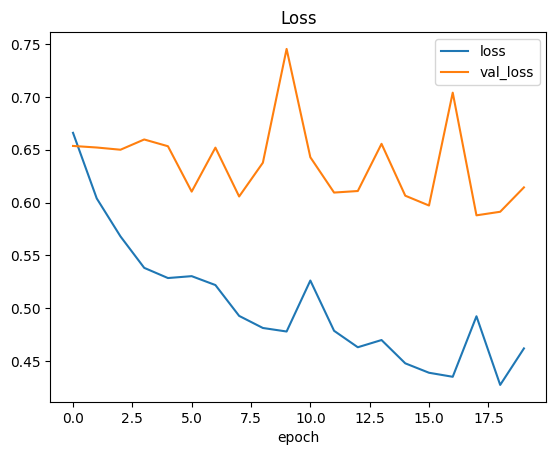

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

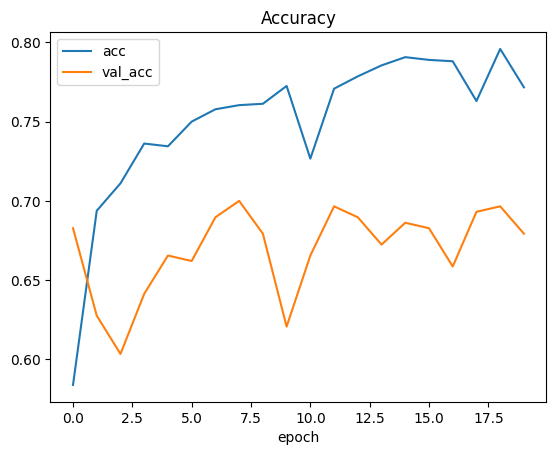

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [49]:
y_pred = model.predict(X_test) > 0.5
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       282
           1       0.73      0.81      0.77       338

    accuracy                           0.74       620
   macro avg       0.74      0.73      0.73       620
weighted avg       0.74      0.74      0.73       620



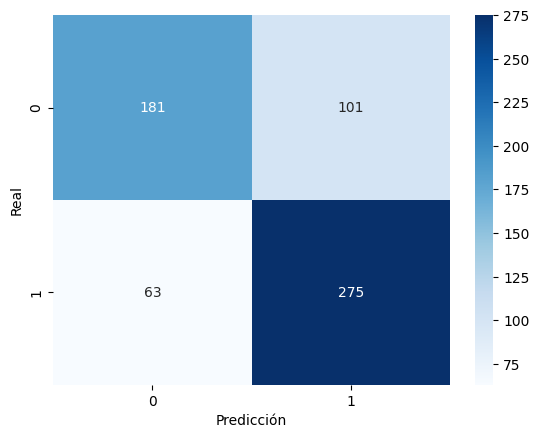

In [50]:
# Heatmap simple
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [51]:
pred_probs = model.predict(X_test)
pred_classes = (pred_probs > 0.5).astype("int32")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


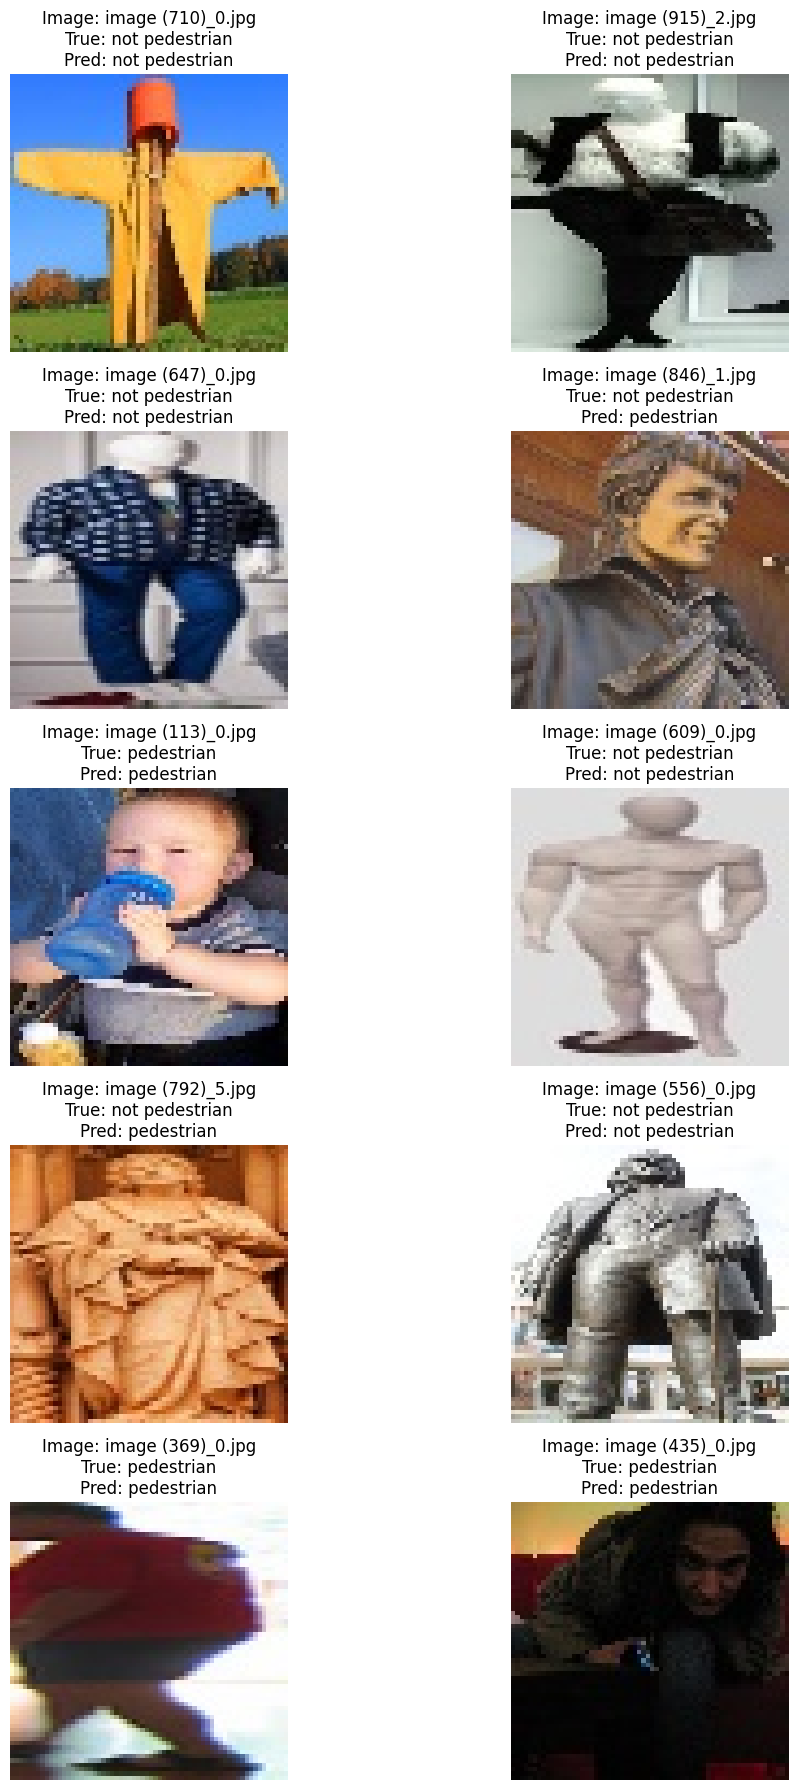

In [52]:
utils.show_predictions(image_ids=id_test, y_true= y_test, y_pred=pred_classes, nrows=nrows, ncols=ncols, figsize=figsize)